#Table of Contents
* [Purpose](#Purpose)
* [Set up](#Set-up)
	* [Function definitions](#Function-definitions)
	* [Interrupt period and frequency definitions](#Interrupt-period-and-frequency-definitions)
	* [Filter coefficients & normalization - low pass and bandpass (1 kHz for 10 kHz sampling)](#Filter-coefficients-&-normalization---low-pass-and-bandpass-%281-kHz-for-10-kHz-sampling%29)
* [Basic filter tests](#Basic-filter-tests)
* [Test with simulated PMT signal](#Test-with-simulated-PMT-signal)
	* [100 ms Window](#100-ms-Window)
		* [Step-by-step](#Step-by-step)
		* [Compare filtered signal with envelope](#Compare-filtered-signal-with-envelope)
	* [500 ms Window](#500-ms-Window)
		* [Step-by-step](#Step-by-step)
		* [Compare filtered signal with envelope](#Compare-filtered-signal-with-envelope)
	* [Noise](#Noise)
		* [Test random functions](#Test-random-functions)
		* [Filtering a noisy 1 kHz signal](#Filtering-a-noisy-1-kHz-signal)
		* [Filtering a noisy DC signal](#Filtering-a-noisy-DC-signal)
* [Next](#Next)


In [1]:
%%javascript
IPython.load_extensions('calico-document-tools');

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
from __future__ import print_function
from scipy import signal

# Purpose

Explore digitally processing expected PMT data from laser-induced fluorescence generated with a sinusoidally modulated laser beam. Use a digital bandpass filter followed by digital demultiplexing and a digital low pass filter to obtain the LIF signal. In this notebook we will model this process with simulated signals.

See _150706_test_filters.ipynb_ for development code and notes, especially for coefficient normalization and index shift to achieve zero-phase filter.

# Set up

## Function definitions

In [33]:
def fir_on_value_in_array(data_array, ii, h):
    '''Calculate FIR filtered value given filter coefficients, array of data, & current index into array of data
    
       Inputs:
           data_array - array of data values
           ii - index current data_array value for which to calculate filtered value
           h - array of filter coefficients
       Returns:
           new filtered value'''
    num_coef = len(h)
    accum = 0
    for k in range(num_coef):
        accum += h[k] * data_array[ii-k]
    return accum

def zero_phase_fir_on_array(data_array, h):
    '''Apply zero-phase FIR filter to array of data given the FIR filter coefficients. Zero-phase in practice
       means that the filtered data is shifted back in time in the output array by (N-1)/2 where N is the
       number of FIR filter coefficients. N must be odd. The first and last (N-1)/2 - 1 values of the filtered
       data array will be zero. 
    
       Inputs:
           data_array - array of data values to be filtered
           h - array of filter coefficients
       Returns:
           array with filtered values'''
    filtered_data = np.zeros(len(data_array))
    n_coef = len(h)
    n_mid_coef = (n_coef-1)//2
    for i in range(n_coef-1, n_total_samples):
        filtered_data[i-n_mid_coef] = fir_on_value_in_array(data_array, i, h)
    return filtered_data

def gain_magn(h, omega):
    '''Calculate gain of FIR filter with coefficients in array h and at normalized frequency omega.
       The coefficient array should be symmetric and the normalized frequency is f_desired/f_sampling.'''
    cos_term, sin_term = 0.0, 0.0
    for k in range(len(h)):
        cos_term += h[k] * np.cos(2.0*np.pi*omega*k)
        sin_term += h[k] * np.sin(2.0*np.pi*omega*k)
    gain_mag = np.sqrt( cos_term**2 + sin_term**2 )
    return gain_mag


In [29]:
us_to_s = 1e-6
us_to_ms = 1e-3
ms_to_s = 1e-3

## Interrupt period and frequency definitions

In [27]:
t_inter_us = 100  # period for calls to interrupt in microseconds
n_samp_cos = 10
freq_samp = 1.0/((t_inter_us*us_to_s))
freq_cos = 1.0/((t_inter_us*us_to_s)*n_samp_cos)
print('cosine freq =', freq_cos, 'Hz')
print('sampling freq =', freq_samp, 'Hz')

cosine freq = 1000.0 Hz
sampling freq = 10000.0 Hz


## Filter coefficients & normalization - low pass and bandpass (1 kHz for 10 kHz sampling)

Calculate coefficients from [FIR Filter Design](http://www.arc.id.au/FilterDesign.html) for Kaiser-Bessel filter generator. 

Low pass filter design parameters: Fa = 0 Hz, Fb = 100 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

Bandpass filter design parameters: Fa = 950 Hz, Fb = 1050 Hz, M(odd) length = 37, dF/2 is 503 Hz (given by calculator), Fs = 10 kHz, Att = 60 dB

In [145]:
lp_coef = [0.000326, 0.000692, 0.001207, 0.001891, 0.002756, 
           0.003806, 0.005036, 0.006430, 0.007961, 0.009591, 
           0.011275, 0.012958, 0.014582, 0.016086, 0.017413, 
           0.018507, 0.019325, 0.019829, 0.020000, 0.019829, 
           0.019325, 0.018507, 0.017413, 0.016086, 0.014582, 
           0.012958, 0.011275, 0.009591, 0.007961, 0.006430, 
           0.005036, 0.003806, 0.002756, 0.001891, 0.001207, 0.000692, 0.000326]

bp_coef = [0.000119, -0.000248, -0.001115, -0.002123, -0.002464, 
           -0.001282, 0.001674, 0.005529, 0.008370, 0.008080, 
           0.003597, -0.004103, -0.012010, -0.016287, -0.014199, 
           -0.005745, 0.005983, 0.016050, 0.020000, 0.016050, 
           0.005983, -0.005745, -0.014199, -0.016287, -0.012010, 
           -0.004103, 0.003597, 0.008080, 0.008370, 0.005529, 
           0.001674, -0.001282, -0.002464, -0.002123, -0.001115, -0.000248, 0.000119] 

n_lp_coef = len(lp_coef)
n_bp_coef = len(bp_coef)

lp_coef_norm = lp_coef/gain_magn(lp_coef, 0.0)
bp_coef_norm = bp_coef/gain_magn(bp_coef, 0.1)

lp20Hz_coef = [0.000081, 0.000167, 0.000286, 0.000438, 0.000626, 
               0.000849, 0.001105, 0.001390, 0.001697, 0.002020, 
               0.002349, 0.002674, 0.002984, 0.003269, 0.003518, 
               0.003723, 0.003875, 0.003968, 0.004000, 0.003968, 
               0.003875, 0.003723, 0.003518, 0.003269, 0.002984, 
               0.002674, 0.002349, 0.002020, 0.001697, 0.001390, 
               0.001105, 0.000849, 0.000626, 0.000438, 0.000286, 0.000167, 0.000081] 

n_lp20Hz_coef = len(lp20Hz_coef)
lp20Hz_coef_norm = lp20Hz_coef/gain_magn(lp20Hz_coef, 0.0)

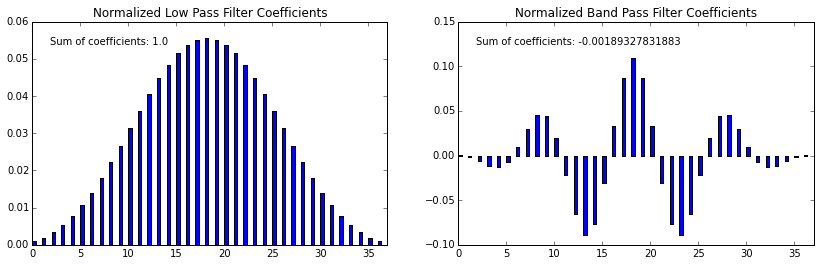

In [24]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(14,4))
index_lp = np.arange(n_lp_coef)
ax.bar(index_lp, lp_coef_norm, 0.35)
ax.set_xlim(0, n_lp_coef)
temptext = 'Sum of coefficients: {}'.format(np.sum(lp_coef_norm))
ax.text(0.05, 0.9, temptext, transform = ax.transAxes)
ax.set_title('Normalized Low Pass Filter Coefficients')
index_bp = np.arange(n_bp_coef)
ax2.bar(index_bp, bp_coef_norm, 0.35)
ax2.set_xlim(0,n_bp_coef)
temptext = 'Sum of coefficients: {}'.format(np.sum(bp_coef_norm))
ax2.text(1.25, 0.9, temptext, transform = ax.transAxes)
ax2.set_title('Normalized Band Pass Filter Coefficients');

# Basic filter tests

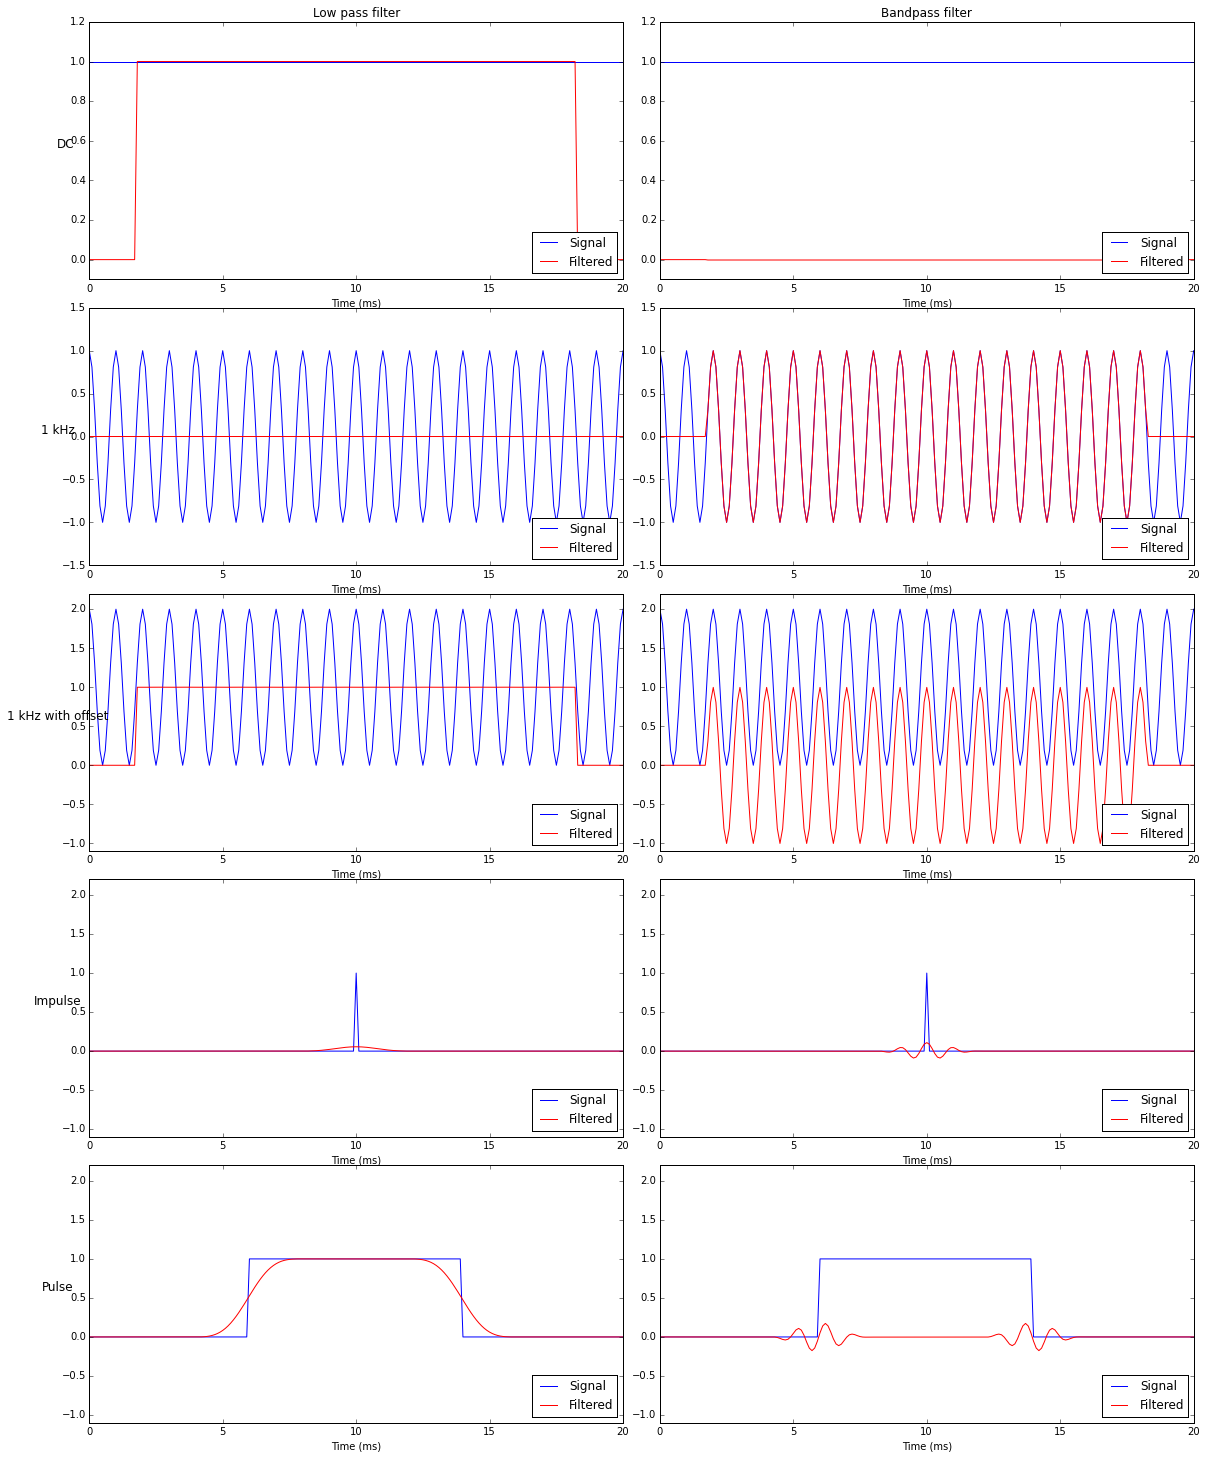

In [172]:
n_total_samples = 201
test_freq = 1000.0

time_dac_output_ms = 1.0e-3 * np.linspace(0, t_inter_us*(n_total_samples-1), n_total_samples)

dc_signal = np.ones(n_total_samples)
dc_signal_lp_out = zero_phase_fir_on_array(dc_signal, lp_coef_norm)
dc_signal_bp_out = zero_phase_fir_on_array(dc_signal, bp_coef_norm)

cos_1kHz = np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
cos_1kHz_lp_out = zero_phase_fir_on_array(cos_1kHz, lp_coef_norm)
cos_1kHz_bp_out = zero_phase_fir_on_array(cos_1kHz, bp_coef_norm)

raised_cos_1kHz = 1.0 + np.cos(2.0*np.pi*test_freq*(time_dac_output_ms * ms_to_s))
raised_cos_1kHz_lp_out = zero_phase_fir_on_array(raised_cos_1kHz, lp_coef_norm)
raised_cos_1kHz_bp_out = zero_phase_fir_on_array(raised_cos_1kHz, bp_coef_norm)

impulse = np.zeros(n_total_samples)
impulse[(n_total_samples-1)/2] = 1.0
impulse_lp_out = zero_phase_fir_on_array(impulse, lp_coef_norm)
impulse_bp_out = zero_phase_fir_on_array(impulse, bp_coef_norm)

pulse = np.zeros(n_total_samples)
pulse_width = 80
pulse[(n_total_samples-1)/2 - pulse_width/2 : (n_total_samples-1)/2 + pulse_width/2] = 1.0
pulse_lp_out = zero_phase_fir_on_array(pulse, lp_coef_norm)
pulse_bp_out = zero_phase_fir_on_array(pulse, bp_coef_norm)



fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(16,20))
fig.tight_layout()

ax.plot(time_dac_output_ms, dc_signal, label='Signal')
ax.plot(time_dac_output_ms, dc_signal_lp_out, 'r', label='Filtered')
ax.legend(loc=4)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('DC', rotation=0, size='large') #http://stackoverflow.com/questions/25812255/row-and-column-headers-in-matplotlibs-subplots
ax.set_ylim(-0.1, 1.2)
ax.set_title('Low pass filter')

ax2.plot(time_dac_output_ms, dc_signal, label='Signal')
ax2.plot(time_dac_output_ms, dc_signal_bp_out, 'r', label='Filtered')
ax2.legend(loc=4)
ax2.set_xlabel('Time (ms)')
#ax2.set_ylabel('Signals')
ax2.set_ylim(-0.1, 1.2)
ax2.set_title('Bandpass filter')

ax3.plot(time_dac_output_ms, cos_1kHz, label='Signal')
ax3.plot(time_dac_output_ms, cos_1kHz_lp_out, 'r', label='Filtered')
ax3.legend(loc=4)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('1 kHz', rotation=0, size='large')
ax3.set_ylim(-1.5, 1.5)

ax4.plot(time_dac_output_ms, cos_1kHz, label='Signal')
ax4.plot(time_dac_output_ms, cos_1kHz_bp_out, 'r', label='Filtered')
ax4.legend(loc=4)
ax4.set_xlabel('Time (ms)')
#ax4.set_ylabel('Signals')
ax4.set_ylim(-1.5, 1.5)

ax5.plot(time_dac_output_ms, raised_cos_1kHz, label='Signal')
ax5.plot(time_dac_output_ms, raised_cos_1kHz_lp_out, 'r', label='Filtered')
ax5.legend(loc=4)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('1 kHz with offset', rotation=0, size='large')
ax5.set_ylim(-1.1, 2.2)

ax6.plot(time_dac_output_ms, raised_cos_1kHz, label='Signal')
ax6.plot(time_dac_output_ms, raised_cos_1kHz_bp_out, 'r', label='Filtered')
ax6.legend(loc=4)
ax6.set_xlabel('Time (ms)')
ax6.set_ylim(-1.1, 2.2)

ax7.plot(time_dac_output_ms, impulse, label='Signal')
ax7.plot(time_dac_output_ms, impulse_lp_out, 'r', label='Filtered')
ax7.legend(loc=4)
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('Impulse', rotation=0, size='large')
ax7.set_ylim(-1.1, 2.2)

ax8.plot(time_dac_output_ms, impulse, label='Signal')
ax8.plot(time_dac_output_ms, impulse_bp_out, 'r', label='Filtered')
ax8.legend(loc=4)
ax8.set_xlabel('Time (ms)')
ax8.set_ylim(-1.1, 2.2)

ax9.plot(time_dac_output_ms, pulse, label='Signal')
ax9.plot(time_dac_output_ms, pulse_lp_out, 'r', label='Filtered')
ax9.legend(loc=4)
ax9.set_xlabel('Time (ms)')
ax9.set_ylabel('Pulse', rotation=0, size='large')
ax9.set_ylim(-1.1, 2.2)

ax10.plot(time_dac_output_ms, pulse, label='Signal')
ax10.plot(time_dac_output_ms, pulse_bp_out, 'r', label='Filtered')
ax10.legend(loc=4)
ax10.set_xlabel('Time (ms)')
ax10.set_ylim(-1.1, 2.2);

# Test with simulated PMT signal

## 100 ms Window

### Step-by-step

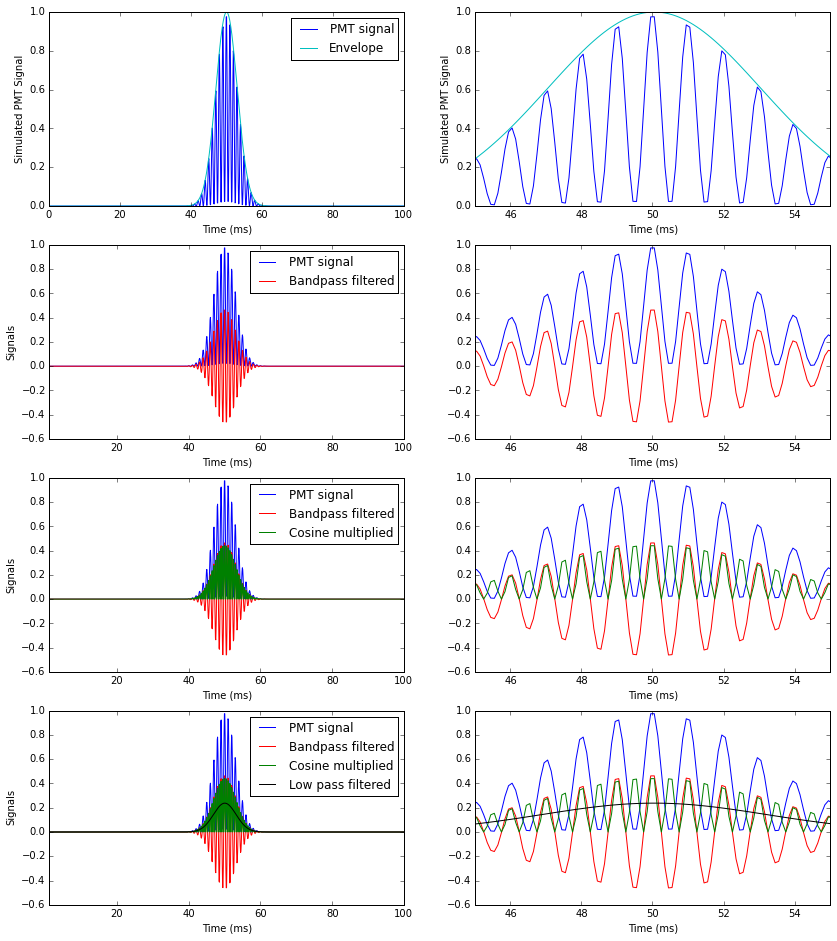

In [92]:
n_total_samples = 1001
cos_freq = 1000.0
time_interrupts_ms = np.linspace(0, n_total_samples*t_inter_us*us_to_ms, num=n_total_samples)

modulation = signal.gaussian(n_total_samples, 30.0)
raised_cos_1kHz = 0.5 * (1.0 + np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s)))
pmt_signal = raised_cos_1kHz * modulation

test_bp_out = zero_phase_fir_on_array(pmt_signal, bp_coef_norm)
test_cos_1kHz = np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s))
test_cos_mult = test_bp_out * test_cos_1kHz
test_lp_out = zero_phase_fir_on_array(test_cos_mult, lp_coef_norm)

fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(14,16))

ax.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax.plot(time_interrupts_ms, modulation, 'c', label='Envelope')
ax.set_xlim(0,100)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Simulated PMT Signal')
ax.legend()

ax2.plot(time_interrupts_ms, pmt_signal)
ax2.plot(time_interrupts_ms, modulation, 'c')
ax2.set_xlim(45,55)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Simulated PMT Signal')

ax3.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax3.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax3.set_xlim(0,100)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Signals')
ax3.legend()

ax4.plot(time_interrupts_ms, pmt_signal)
ax4.plot(time_interrupts_ms, test_bp_out, 'r')
ax4.set_xlim(45,55)
ax4.set_xlabel('Time (ms)')
#ax4.set_ylabel('Simulated PMT Signal')

ax5.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax5.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax5.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax5.set_xlim(0,100)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Signals')
ax5.legend()

ax6.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax6.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax6.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax6.set_xlim(45,55)
ax6.set_xlabel('Time (ms)')

ax7.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax7.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax7.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax7.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax7.set_xlim(0,100)
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('Signals')
ax7.legend()

ax8.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax8.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax8.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax8.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax8.set_xlim(45,55)
ax8.set_xlabel('Time (ms)');

### Compare filtered signal with envelope

1.0 0.238010958621


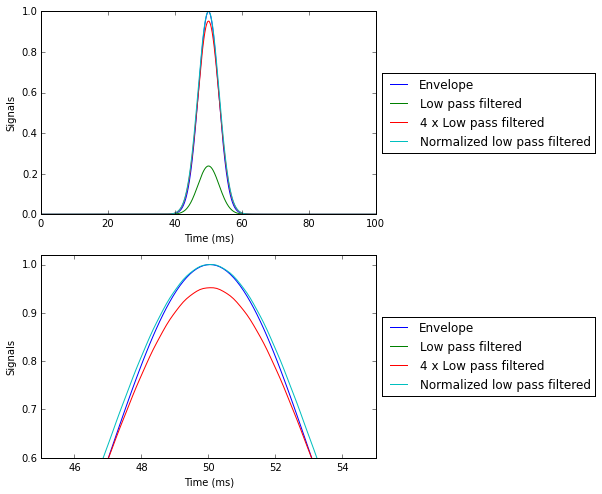

In [108]:
fig, (ax, ax2) = plt.subplots(2, figsize=(6,8))
ax.plot(time_interrupts_ms, modulation, label='Envelope')
ax.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax.set_xlim(0,100)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.plot(time_interrupts_ms, modulation, label='Envelope')
ax2.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax2.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax2.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax2.set_xlim(45,55)
ax2.set_ylim(0.6,1.02)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Signals')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print(max(modulation), max(test_lp_out))

## 500 ms Window

### Step-by-step

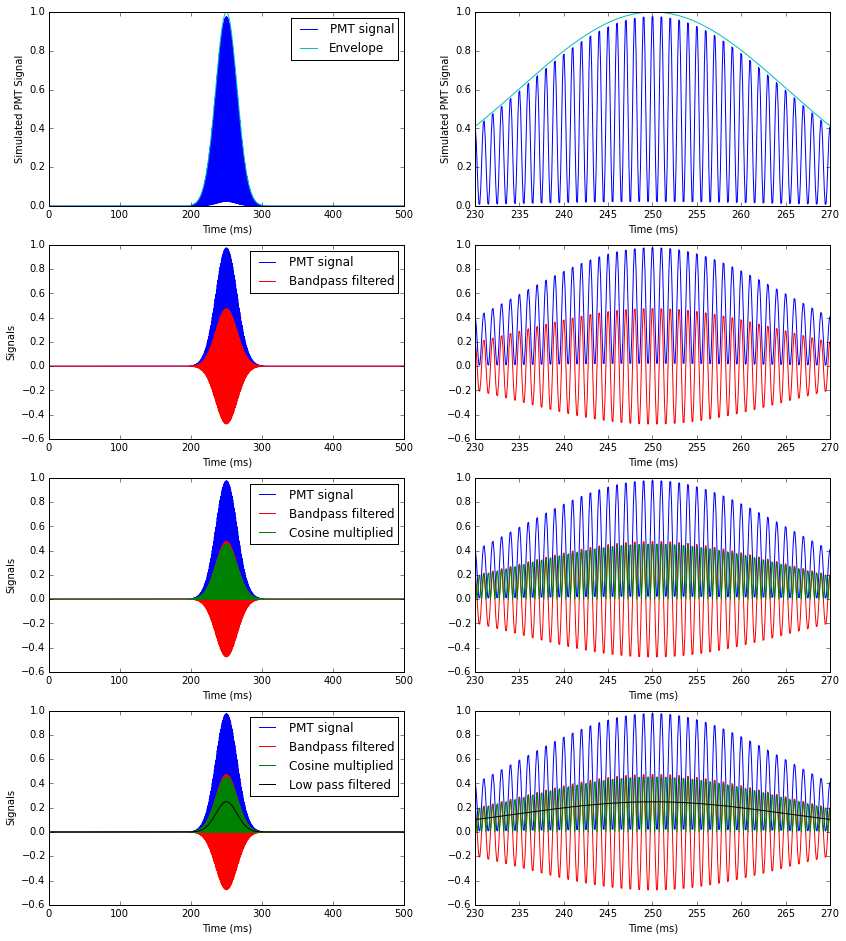

In [111]:
n_total_samples = 5001
cos_freq = 1000.0
xlim_min, xlim_max = 0, 500
xlim2_min, xlim2_max = 230, 270
time_interrupts_ms = np.linspace(0, n_total_samples*t_inter_us*us_to_ms, num=n_total_samples)

modulation = signal.gaussian(n_total_samples, 5*30.0)
raised_cos_1kHz = 0.5 * (1.0 + np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s)))
pmt_signal = raised_cos_1kHz * modulation

test_bp_out = zero_phase_fir_on_array(pmt_signal, bp_coef_norm)
test_cos_1kHz = np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s))
test_cos_mult = test_bp_out * test_cos_1kHz
test_lp_out = zero_phase_fir_on_array(test_cos_mult, lp_coef_norm)

fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(14,16))

ax.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax.plot(time_interrupts_ms, modulation, 'c', label='Envelope')
ax.set_xlim(xlim_min, xlim_max)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Simulated PMT Signal')
ax.legend()

ax2.plot(time_interrupts_ms, pmt_signal)
ax2.plot(time_interrupts_ms, modulation, 'c')
ax2.set_xlim(xlim2_min, xlim2_max)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Simulated PMT Signal')

ax3.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax3.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Signals')
ax3.legend()

ax4.plot(time_interrupts_ms, pmt_signal)
ax4.plot(time_interrupts_ms, test_bp_out, 'r')
ax4.set_xlim(xlim2_min, xlim2_max)
ax4.set_xlabel('Time (ms)')
#ax4.set_ylabel('Simulated PMT Signal')

ax5.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax5.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax5.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax5.set_xlim(xlim_min, xlim_max)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Signals')
ax5.legend()

ax6.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax6.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax6.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax6.set_xlim(xlim2_min, xlim2_max)
ax6.set_xlabel('Time (ms)')

ax7.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax7.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax7.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax7.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax7.set_xlim(xlim_min, xlim_max)
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('Signals')
ax7.legend()

ax8.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax8.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax8.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax8.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax8.set_xlim(xlim2_min, xlim2_max)
ax8.set_xlabel('Time (ms)');

### Compare filtered signal with envelope

1.0 0.249552358099


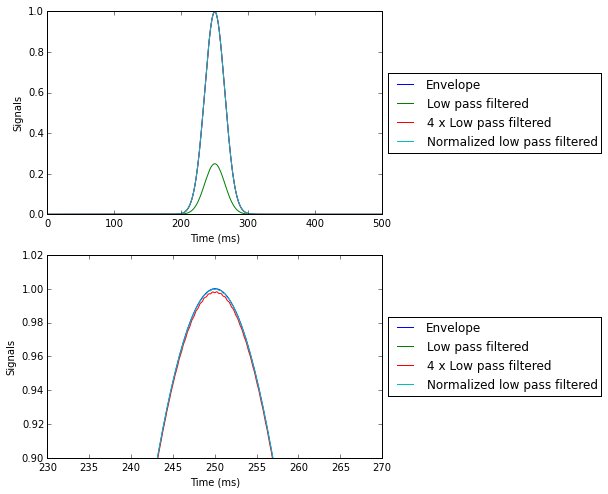

In [113]:
fig, (ax, ax2) = plt.subplots(2, figsize=(6,8))
ax.plot(time_interrupts_ms, modulation, label='Envelope')
ax.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax.set_xlim(xlim_min, xlim_max)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.plot(time_interrupts_ms, modulation, label='Envelope')
ax2.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax2.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax2.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax2.set_xlim(xlim2_min, xlim2_max)
ax2.set_ylim(0.9,1.02)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Signals')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print(max(modulation), max(test_lp_out))

##Noise

### Test random functions

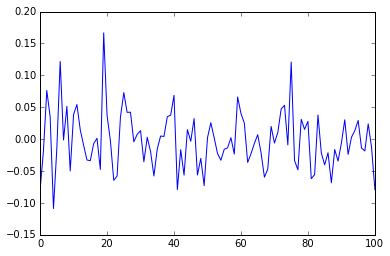

In [117]:
nse1 = 0.05*np.random.randn(101)
plt.plot(nse1)

In [126]:
print(np.average(nse1), np.std(nse1))

-0.0020135353787 0.045128493441


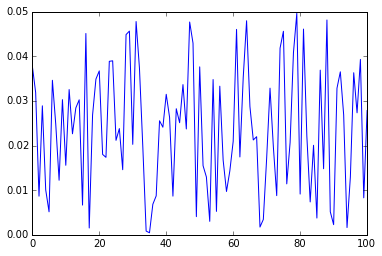

In [118]:
nse2 = 0.05*np.random.rand(101)
plt.plot(nse2)

In [120]:
print(np.average(nse2), np.std(nse2))

0.0239019770472 0.0139026876074


### Filtering a noisy 1 kHz signal

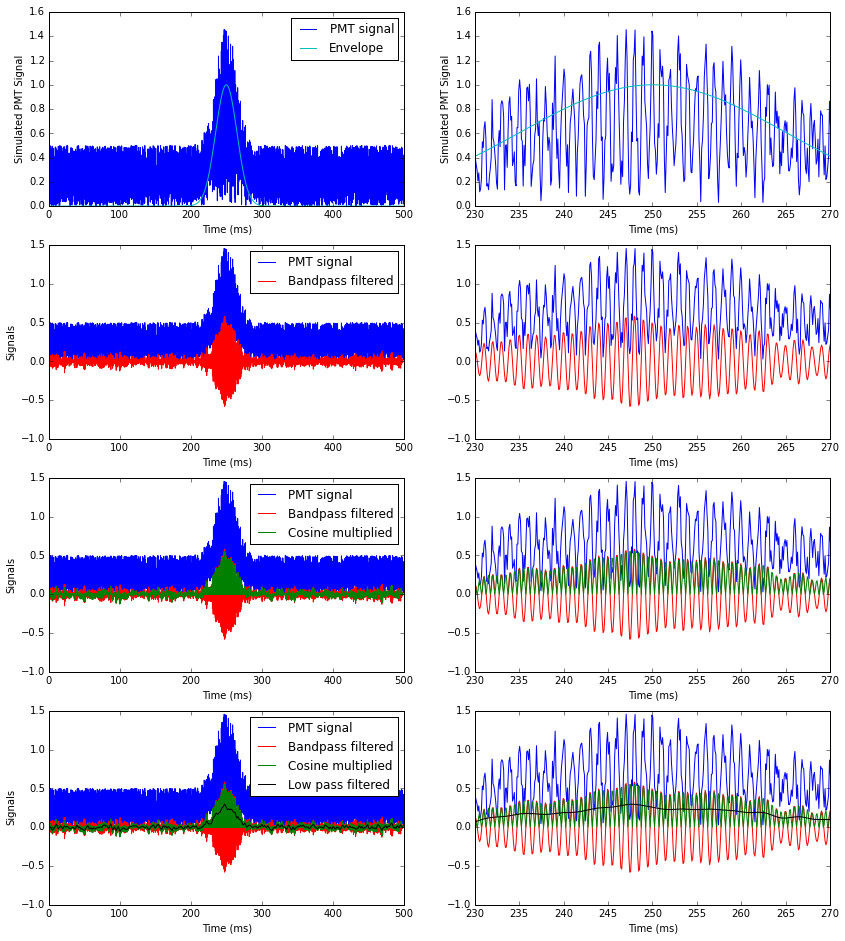

In [160]:
n_total_samples = 5001
cos_freq = 1000.0
xlim_min, xlim_max = 0, 500
xlim2_min, xlim2_max = 230, 270
time_interrupts_ms = np.linspace(0, n_total_samples*t_inter_us*us_to_ms, num=n_total_samples)

modulation = signal.gaussian(n_total_samples, 5*30.0)
raised_cos_1kHz = 0.5 * (1.0 + np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s)))
noise05 = 0.5*np.random.rand(n_total_samples)
pmt_signal = raised_cos_1kHz * modulation + noise05

test_bp_out = zero_phase_fir_on_array(pmt_signal, bp_coef_norm)
test_cos_1kHz = np.cos(2.0*np.pi*cos_freq*(time_interrupts_ms * ms_to_s))
test_cos_mult = test_bp_out * test_cos_1kHz
test_lp_out = zero_phase_fir_on_array(test_cos_mult, lp_coef_norm)

fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(14,16))

ax.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax.plot(time_interrupts_ms, modulation, 'c', label='Envelope')
ax.set_xlim(xlim_min, xlim_max)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Simulated PMT Signal')
ax.legend()

ax2.plot(time_interrupts_ms, pmt_signal)
ax2.plot(time_interrupts_ms, modulation, 'c')
ax2.set_xlim(xlim2_min, xlim2_max)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Simulated PMT Signal')

ax3.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax3.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Signals')
ax3.legend()

ax4.plot(time_interrupts_ms, pmt_signal)
ax4.plot(time_interrupts_ms, test_bp_out, 'r')
ax4.set_xlim(xlim2_min, xlim2_max)
ax4.set_xlabel('Time (ms)')
#ax4.set_ylabel('Simulated PMT Signal')

ax5.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax5.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax5.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax5.set_xlim(xlim_min, xlim_max)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Signals')
ax5.legend()

ax6.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax6.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax6.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax6.set_xlim(xlim2_min, xlim2_max)
ax6.set_xlabel('Time (ms)')

ax7.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax7.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax7.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax7.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax7.set_xlim(xlim_min, xlim_max)
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('Signals')
ax7.legend()

ax8.plot(time_interrupts_ms, pmt_signal, label='PMT signal')
ax8.plot(time_interrupts_ms, test_bp_out, 'r', label='Bandpass filtered')
ax8.plot(time_interrupts_ms, test_cos_mult, 'g', label='Cosine multiplied')
ax8.plot(time_interrupts_ms, test_lp_out, 'k', label='Low pass filtered')
ax8.set_xlim(xlim2_min, xlim2_max)
ax8.set_xlabel('Time (ms)');

1.0 0.295669087213


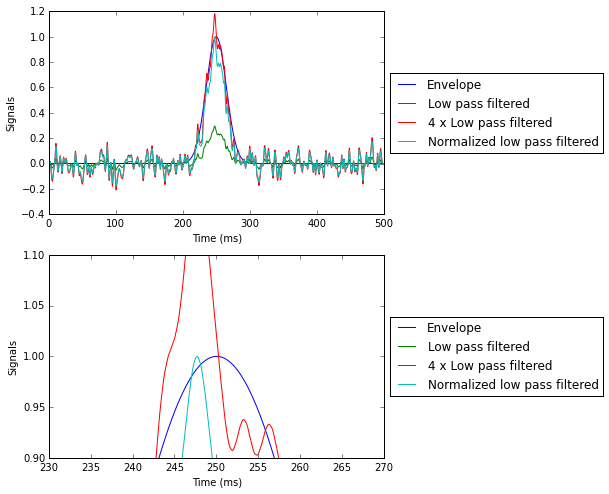

In [161]:
fig, (ax, ax2) = plt.subplots(2, figsize=(6,8))
ax.plot(time_interrupts_ms, modulation, label='Envelope')
ax.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax.set_xlim(xlim_min, xlim_max)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Signals')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.plot(time_interrupts_ms, modulation, label='Envelope')
ax2.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')
ax2.plot(time_interrupts_ms, 4*test_lp_out, label='4 x Low pass filtered')
ax2.plot(time_interrupts_ms, test_lp_out*(max(modulation)/max(test_lp_out)), label='Normalized low pass filtered')
ax2.set_xlim(xlim2_min, xlim2_max)
ax2.set_ylim(0.9,1.1)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Signals')
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print(max(modulation), max(test_lp_out))

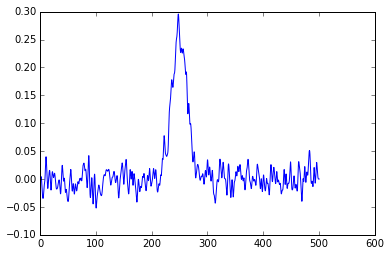

In [162]:
fig, ax = plt.subplots()
ax.plot(time_interrupts_ms, test_lp_out, label='Low pass filtered')

### Filtering a noisy DC signal

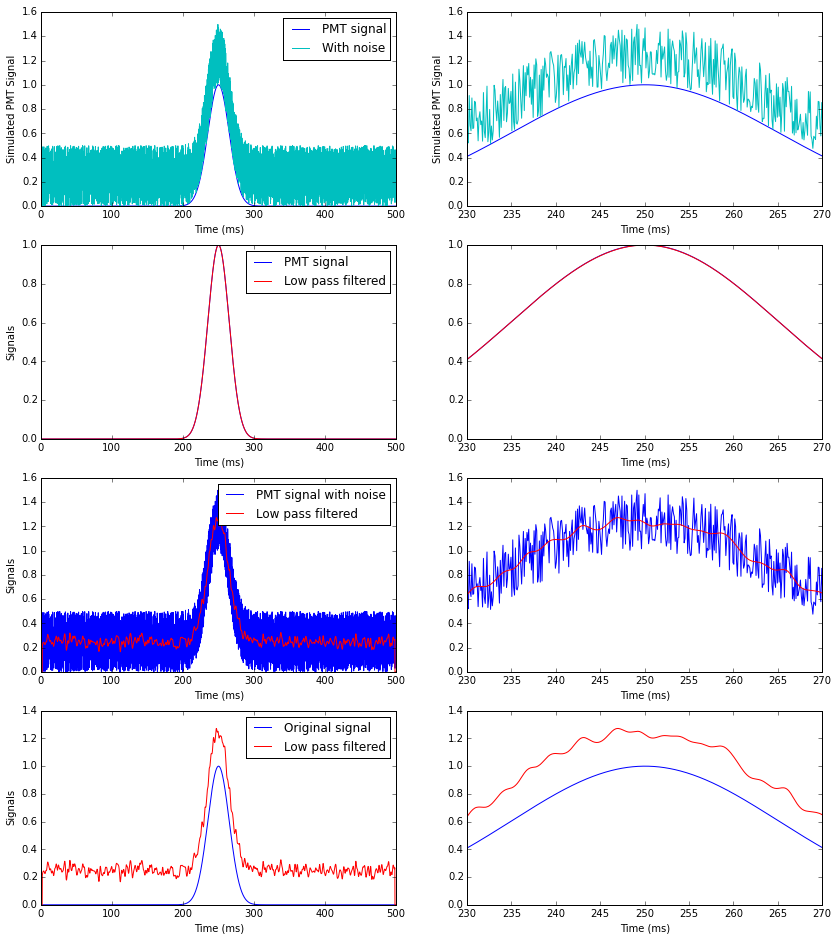

In [158]:
n_total_samples = 5001
cos_freq = 1000.0
xlim_min, xlim_max = 0, 500
xlim2_min, xlim2_max = 230, 270
time_interrupts_ms = np.linspace(0, n_total_samples*t_inter_us*us_to_ms, num=n_total_samples)

modulation = signal.gaussian(n_total_samples, 5*30.0)
noise05 = 0.5*np.random.rand(n_total_samples)
pmt_signal_no_cos = modulation + noise05

modulation_lp_out = zero_phase_fir_on_array(modulation, lp_coef_norm)
testDC_lp_out = zero_phase_fir_on_array(pmt_signal_no_cos, lp_coef_norm)

fig, ((ax, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(14,16))

ax.plot(time_interrupts_ms, modulation, label='PMT signal')
ax.plot(time_interrupts_ms, pmt_signal_no_cos, 'c', label='With noise')
ax.set_xlim(xlim_min, xlim_max)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Simulated PMT Signal')
ax.legend()

ax2.plot(time_interrupts_ms, modulation, label='PMT signal')
ax2.plot(time_interrupts_ms, pmt_signal_no_cos, 'c', label='With noise')
ax2.set_xlim(xlim2_min, xlim2_max)
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Simulated PMT Signal')

ax3.plot(time_interrupts_ms, modulation, label='PMT signal')
ax3.plot(time_interrupts_ms, modulation_lp_out, 'r', label='Low pass filtered')
ax3.set_xlim(xlim_min, xlim_max)
ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Signals')
ax3.legend()

ax4.plot(time_interrupts_ms, modulation, label='PMT signal')
ax4.plot(time_interrupts_ms, modulation_lp_out, 'r', label='Low pass filtered')
ax4.set_xlim(xlim2_min, xlim2_max)
ax4.set_xlabel('Time (ms)')
#ax4.set_ylabel('Simulated PMT Signal')

ax5.plot(time_interrupts_ms, pmt_signal_no_cos, label='PMT signal with noise')
ax5.plot(time_interrupts_ms, testDC_lp_out, 'r', label='Low pass filtered')
ax5.set_xlim(xlim_min, xlim_max)
ax5.set_xlabel('Time (ms)')
ax5.set_ylabel('Signals')
ax5.legend()

ax6.plot(time_interrupts_ms, pmt_signal_no_cos, label='PMT signal with noise')
ax6.plot(time_interrupts_ms, testDC_lp_out, 'r', label='Low pass filtered')
ax6.set_xlim(xlim2_min, xlim2_max)
ax6.set_xlabel('Time (ms)')

ax7.plot(time_interrupts_ms, modulation, label='Original signal')
ax7.plot(time_interrupts_ms, testDC_lp_out, 'r', label='Low pass filtered')
ax7.set_xlim(xlim_min, xlim_max)
ax7.set_xlabel('Time (ms)')
ax7.set_ylabel('Signals')
ax7.legend()

ax8.plot(time_interrupts_ms, modulation, label='Original signal')
ax8.plot(time_interrupts_ms, testDC_lp_out, 'r', label='Low pass filtered')
ax8.set_xlim(xlim2_min, xlim2_max)
ax8.set_xlabel('Time (ms)');

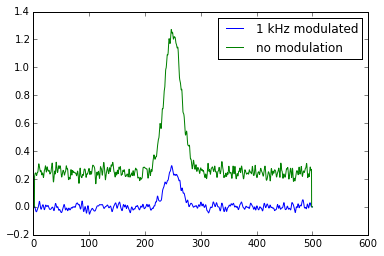

In [163]:
fig, ax = plt.subplots()
ax.plot(time_interrupts_ms, test_lp_out, label='1 kHz modulated')
ax.plot(time_interrupts_ms, testDC_lp_out, label='no modulation')
ax.legend()

Calculate average dark value, standard deviation of dark signal, and SNR for max value for both cases (1 kHz modulated and DC).

In [176]:
print(np.average(test_lp_out[:1500]), np.std(test_lp_out[:1500]), 
      (np.max(test_lp_out)-np.average(test_lp_out[:1500]))/np.std(test_lp_out[:1500]))
print(np.average(testDC_lp_out[:1500]), np.std(testDC_lp_out[:1500]), 
      (np.max(testDC_lp_out)-np.average(testDC_lp_out[:1500]))/np.std(testDC_lp_out[:1500]))

-0.00456204140129 0.0177777040041 16.8880710661
0.248610250091 0.0401894481066 25.4620994317


Note that the DC case gives a better SNR (the last number in the above lines). However, it does not include 1/f noise, the avoidance of which is the point of modulating at 1 kHz.

# Next

- Use a realistic noise model (1/f noise plus white noise)